## **Phase 1 - Modeling**

This notebook initiates the supervised modeling phase of the BioPred_DS pipeline.  Our objective is to train machine learning models to predict compound bioactivity (active vs inactive) against selected GABA-A receptor targets, using a curated dataset of filtered chemical descriptors and Morgan fingerprints.

The goals of this notebook are:

- Train and evaluate multiple classification models (XGBoost, LGBM, etc.)
- Once the best model has been identified, tune with BayesOpt using Optuna.
- Use ROC-AUC as the primary scoring metric within the model.
- Save our best model as a .pkl file and save any important data needed for our results notebook.
- Decision the optimized model, examining the threshold and preparing for the next notebook.
  

In [1]:
import pandas as pd

# Read in our dataset from our feature engineering ntbk to use here.
df = pd.read_csv("../data/processed/phase1_modeling.csv")

# Sanity check and review of data
print(df.shape)
print(df.head(10))


(1443, 2074)
   MaxPartialCharge  MinPartialCharge  BCUT2D_MRLOW  BCUT2D_MWHI    AvgIpc  \
0          0.280202         -0.507167      0.481619    16.255292  2.854478   
1          0.356812         -0.488892      0.051445    16.533323  3.115749   
2          0.280202         -0.488119      0.309943    16.477394  3.100142   
3          0.280202         -0.495970      0.419726    16.465711  2.919463   
4          0.280200         -0.488891      0.306434    16.476995  3.103809   
5          0.280200         -0.486619      0.309215    16.477641  3.103723   
6          0.280200         -0.488891      0.306434    35.495692  3.102918   
7          0.354241         -0.461321      0.051934    16.532691  2.763097   
8          0.247917         -0.313200     -0.116446    35.495691  2.584084   
9          0.354624         -0.496743      0.051412    16.533274  2.929485   

   SlogP_VSA2  BCUT2D_LOGPLOW  BCUT2D_MWLOW  PEOE_VSA9  BalabanJ  ...  \
0   19.870991       -2.134106     10.138253  27.493236 

In [2]:
# Define X and y
X = df.drop(columns = ['active'])
y = df['active']

#### Perform the train/test/split step to separate our data for the modeling.  We will just use a standard 80/20 split here.  We will take advantage of the stratify param to balance our active target as well.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = y, # important to use here since it balances our active class
    random_state = 42
)


#### Okay, we will now run a loop for 8 different classification models to see their results.  We will just run mostly base params in this first run, just to see initial performance.  Since ROC-AUC is also our main metric we will be plotting the curve for each model and showing the results table at the end.

Training model: LogisticRegression


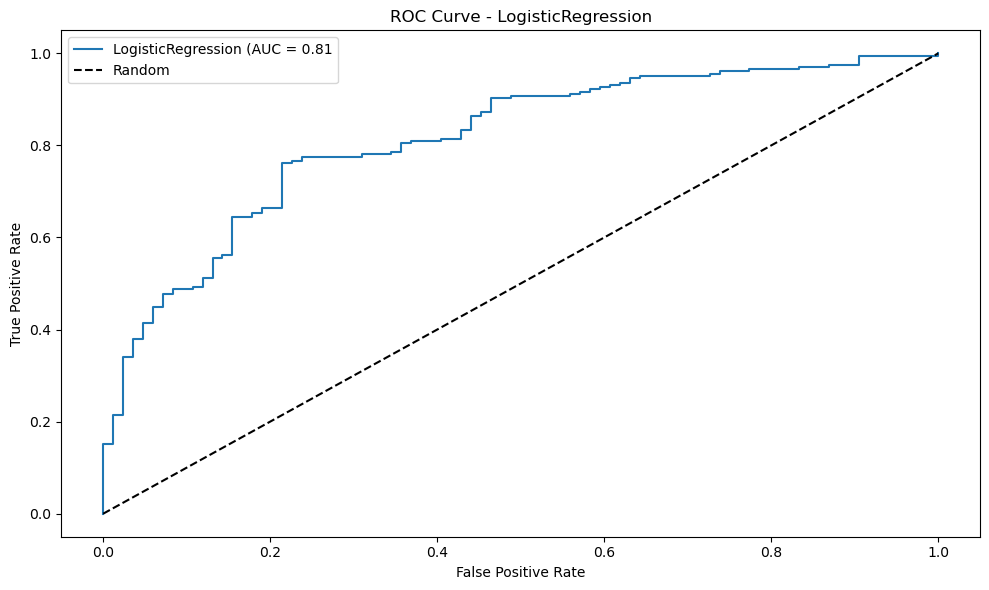

Training model: RandomForest


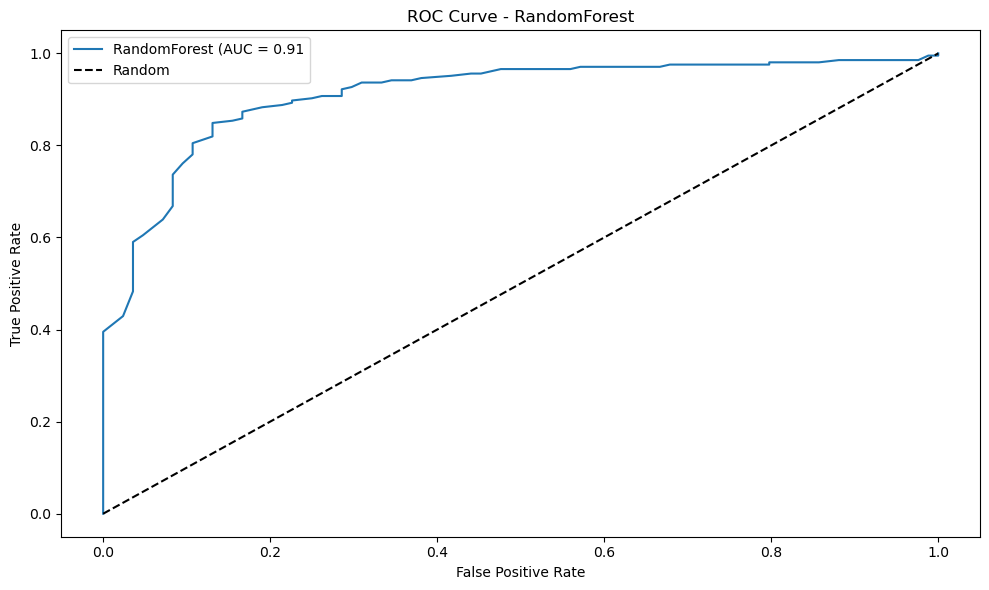

Training model: ExtraTrees


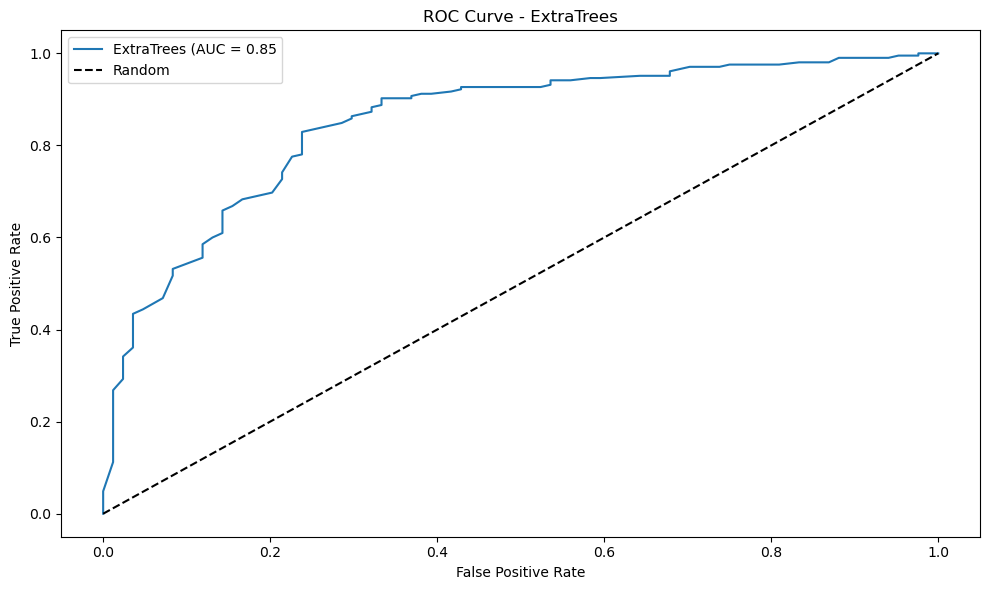

Training model: GradientBoosting


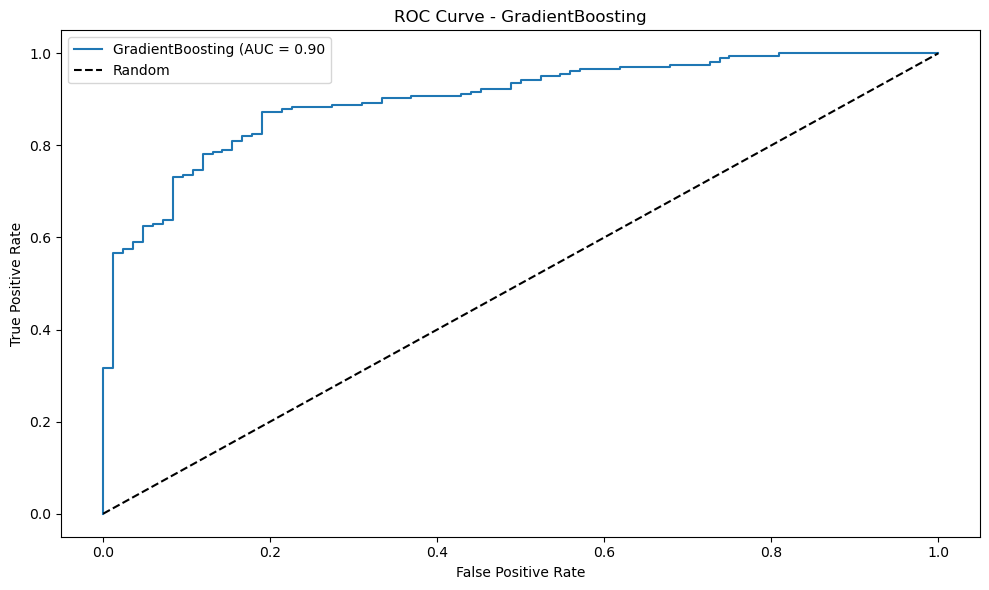

Training model: XGBoost
XGBoost model and arrays saved to: /home/ryanm/BioPred_DS/artifacts/models/xgboost_phase1.pkl


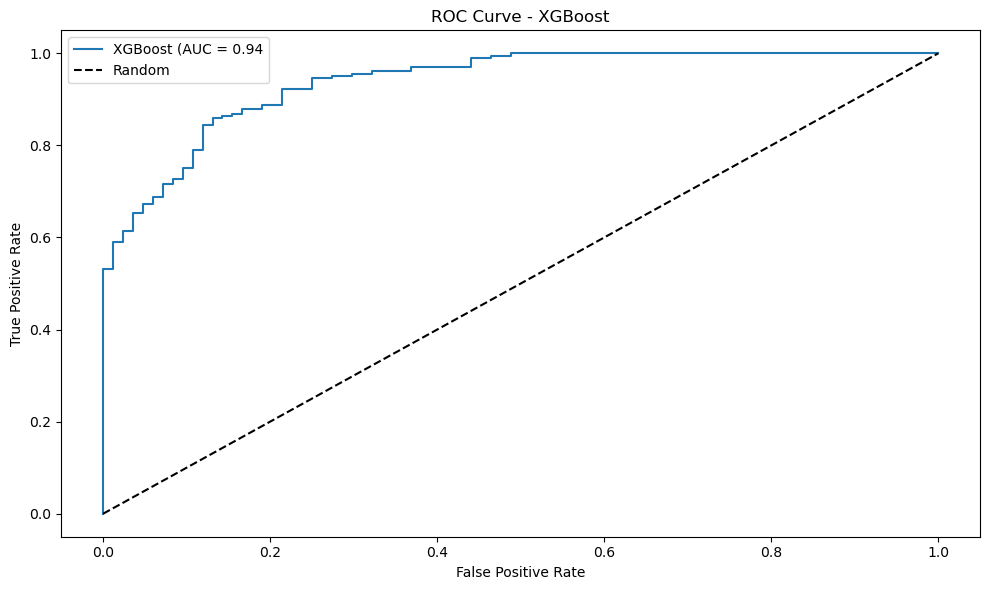

Training model: LightGBM
[LightGBM] [Info] Number of positive: 819, number of negative: 335
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6208
[LightGBM] [Info] Number of data points in the train set: 1154, number of used features: 549
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.709705 -> initscore=0.893954
[LightGBM] [Info] Start training from score 0.893954


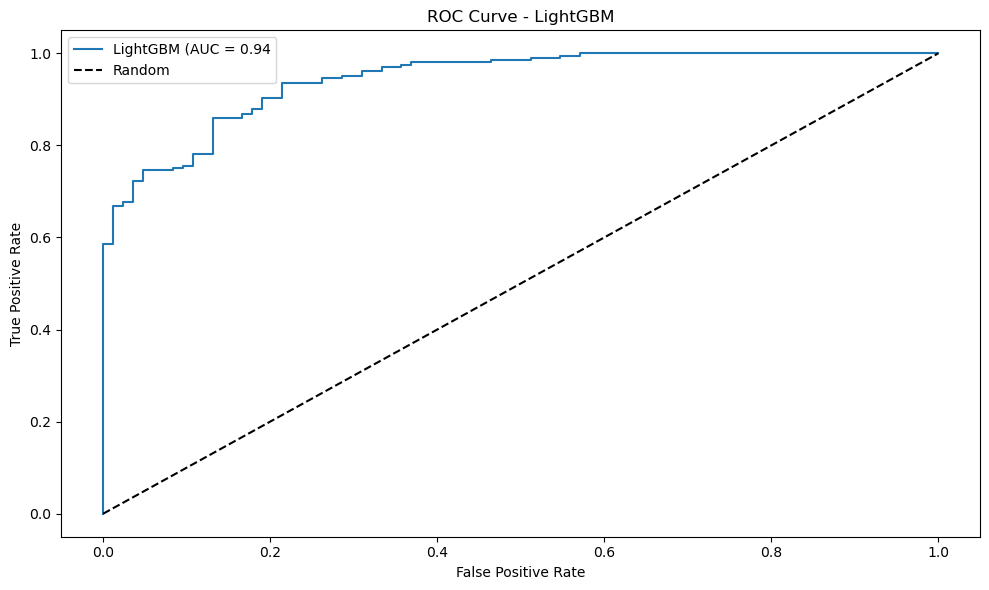

Training model: DecisionTree


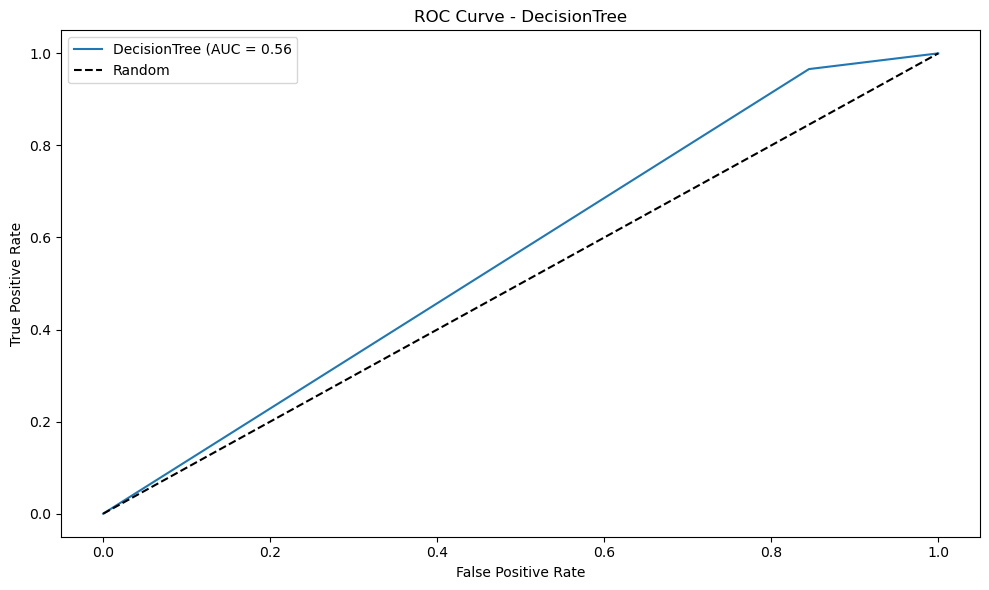

Training model: AdaBoost


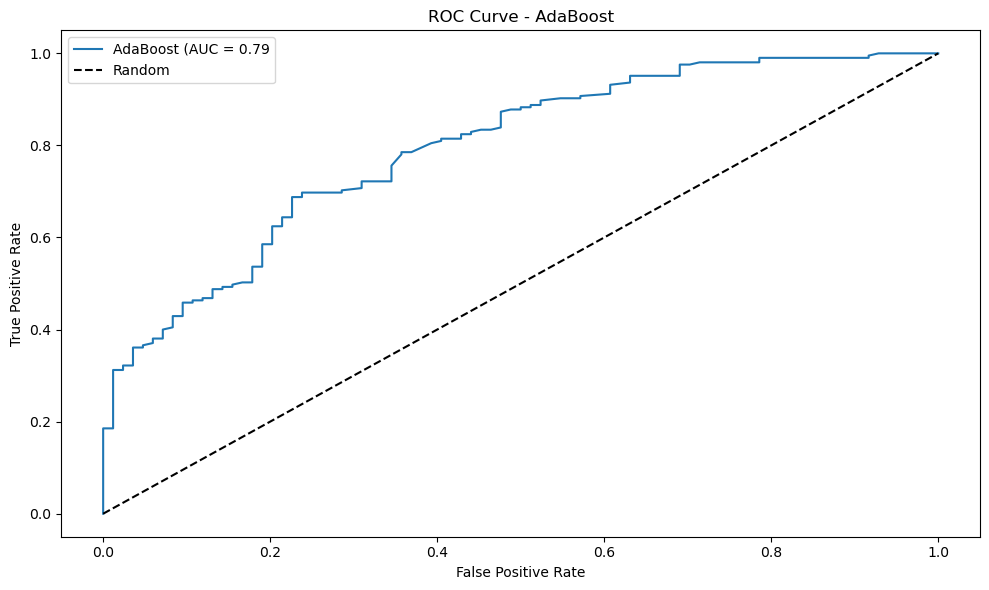

,Model,ROC AUC,PR AUC,Precision,Recall,F1 Score
5,LightGBM,0.943031,0.976057,0.898148,0.946341,0.921615
4,XGBoost,0.938269,0.973145,0.900000,0.921951,0.910843
1,RandomForest,0.910743,0.961825,0.869369,0.941463,0.903981
3,GradientBoosting,0.900174,0.957961,0.845455,0.907317,0.875294
2,ExtraTrees,0.849710,0.926119,0.850000,0.912195,0.880000
0,LogisticRegression,0.814344,0.913268,0.826087,0.834146,0.830097
7,AdaBoost,0.793990,0.903237,0.785714,0.912195,0.844244
6,DecisionTree,0.560308,0.863067,0.736059,0.965854,0.835443


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    precision_score,
    recall_score,
    f1_score,
    roc_curve
)

# Model dictionary set up for our for loop
models = {
    "LogisticRegression" : LogisticRegression(max_iter = 10000),
    "RandomForest" : RandomForestClassifier(),
    "ExtraTrees" : ExtraTreesClassifier(),
    "GradientBoosting" : GradientBoostingClassifier(),
    "XGBoost" : XGBClassifier(eval_metric = 'auc'),
    "LightGBM" : LGBMClassifier(),
    "DecisionTree" : DecisionTreeClassifier(max_depth = 1),
    "AdaBoost" : AdaBoostClassifier()
}

# Training loop with logging
results = []

for name, model in models.items():
    print(f"Training model: {name}")
            
    # Train model
    model.fit(X_train, y_train)

    # Predict probabilities and labels, quick if/else to use predict_proba for those models that have it.
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_proba = model.decision_function(X_test)

    y_pred = model.predict(X_test)

    # Calculate metrics
    roc_auc = roc_auc_score(y_test, y_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # Calculate the pr_auc to add into our metrics below
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_vals, precision_vals) 

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize = (10, 6))
    plt.plot(fpr, tpr, label = f"{name} (AUC = {roc_auc:.2f}")
    plt.plot([0,1],[0,1], "k--", label = "Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {name}")
    plt.legend()
    plt.tight_layout()
    if name == 'XGBoost': # Save chosen model to images folder for the ROC Curve
        plt.savefig(f"../images/roc_curve_{name.lower()}.png")
        
        # Save prediction arrays
        np.save("../artifacts/arrays/X_test_phase1.npy", X_test)
        np.save("../artifacts/arrays/y_test_phase1.npy", y_test)
        np.save("../artifacts/arrays/y_proba_phase1.npy", y_proba)
        # Save full X for SHAP later
        X.to_pickle("../artifacts/arrays/X_model_input_phase1.pkl")

        # Important: set path otherwise will error
        model_path = Path("../artifacts/models/xgboost_phase1.pkl").resolve() # saving the model to a .pkl file
        joblib.dump(model, model_path)
        # Verify data saved
        print("XGBoost model and arrays saved to:", model_path)
        
    plt.show()

    # Store results for table comparison
    results.append({
        "Model" : name,
        "ROC AUC" : roc_auc,
        "PR AUC" : pr_auc,
        "Precision" : precision,
        "Recall" : recall,
        "F1 Score" : f1,
    })

# Output the results in a comparison metrics table
results_df = pd.DataFrame(results).sort_values(by = ["PR AUC", "ROC AUC"], ascending = False)
display(results_df)

#### Across 8 supervised classifiers evaluated on the deduplicated Phase 1 dataset, **tree-based ensemble methods consistenly outperfomed linear and weak learners.""

While **LightGBM** delivered the highest initial scores (ROC AUC = 0.943, PR AUC = 0.976), the performance gap with **XGBoost** was minimal (ROC AUC = 0.938, PR AUC = 0.973).  However, we ultimately selected **XGBoost** as the final model for downstream evaluation and deployment for the following reasons:

-**Production Relevance**: XGBoost remains a more common industry standard in production pipelines, especially in pharma ML workflows.

-**Hyperparameter Flexibility**: XGBoost offers greater granularity and robustness during tuning.  LightGBM, while fast, is optimized more for rapid prototyping.

-**Convergence Control**: XGBoost supports finer control over convergence (e.g., early stopping), which enables better monitoring and interpretability of optimization curves.

This decision aligns with our downstream goals of delivering a **reliable, interpretable, and extensible screening model** for future production use.

The consistent dominance of ensemble methods (LightGBM, XGBoost, Random Forest) reinforces the notion that **nonlinear, high-capacity learners are better suited** for molecular activity prediction tasks involving structurally rich compound features.

The inclusion of lower-performing models such as AdaBoost and DecisionTree serves to validate that the dataset's structure requires more expressive ensemble methods, especially for high-dimensional features like the Morgan fingerprints used.

#### Having identified XGBoost as our chosen classifier model in our initial evaluation (ROC AUC = 0.938, PR AUC = 0.973), we now proceed to optimize its hyperparameters using **Bayesian Optimization via Optuna**.  While the model already demonstrates strong baseline performance without tuning, our objective is to extract any remaining predictive signal by exploring the hyperparameter space efficiently.

#### We recognize that significant performance gains will be unlikely at this stage; however, even marginal improvements can enhance model robustness and compound prioritization in downstream phases.  

In [5]:
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import average_precision_score

# Clean up excessive potential warnings from output
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Establish trial for the Optuna search
def objective(trial):
    # Hyperparameter search space
    params = {
        "n_estimators" : trial.suggest_int("n_estimators", 100, 1000),
        "max_depth" : trial.suggest_int("max_depth", 3, 12),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-3, 0.3, log = True),
        "subsample" : trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha" : trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda" : trial.suggest_float("reg_lambda", 0.0, 1.0),
        "min_child_weight" : trial.suggest_float("min_child_weight", 1, 10),
        "eval_metric" : 'aucpr',
        "use_label_encoder" : False,
        "verbosity" : 0
    }

    # Use our XGBClassifier again here, with all the params.
    model = XGBClassifier(**params)
    
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_train, y_train, cv = cv, scoring = 'average_precision')
    
    return scores.mean()

# Launch study
study = optuna.create_study(
    direction = 'maximize',
    pruner = optuna.pruners.MedianPruner(n_startup_trials = 10, n_warmup_steps = 5)
)
study.optimize(objective, n_trials = 100, show_progress_bar = True)

# Show best results
print("Best PR AUC:", study.best_value)
print("Best hyperparameters:", study.best_params)



  0%|          | 0/100 [00:00<?, ?it/s]

Best PR AUC: 0.9662648044021882
Best hyperparameters: {'n_estimators': 369, 'max_depth': 11, 'learning_rate': 0.024753260427124144, 'subsample': 0.5795140294920013, 'colsample_bytree': 0.7076666962990021, 'reg_alpha': 0.5209226196382039, 'reg_lambda': 0.3177851299862748, 'min_child_weight': 1.784998795635734}


### Model Finalization: Base XGBoost Outperforms Tuned Version

After conducting hyperparamter tuning via **Bayesian Optimization with Optuna**, we evaluated the tuned XGBoost model against our original base version.  Despite the extensive tuning effort, the optimized model achieved a strong **PR AUC of 0.966** on the hold-out test set - validating the model's stability and robustness.  However, the **original base model performed slightly better**, achieving a **PR AUC of 0.973**, alongside a higher ROC AUC.  This outcome highlights a critical point in model development:  when the baseline is already well-regularized and you start to see diminishing returns in performance.  As such, we finalized the **original base XGBoost model** as the production-ready model.  All downstream evaluation metrics (e.g., EF@1%, Precision@K, rediscovery validation, SHAP interpretability) are computed using this selected base model.

#### After selecting XGBoost as our final model through we now shift from modeling performance to actionable decisioning.

The classifier outputs a probability for each compound indicating how likely it is to be "active" against the target.  To use these probabilities in downstream screening or prioritization, a threshold must be chosen-i.e., at what point do we consider a prediction confident enough to label a compound as "active"?

Here in this section to finalize our modeling notebook we will examing two thresholding strategies:

-**Precision-based thresholding** prioritizes the accuracy of the predicted actives, which may help reduce false positives in a shortlist.

-**Recall-based thresholding** prioritizes recovering as many true actives as possible, note though potentially at the cost of including more false positives.

By analyzing the trade-offs between these strategies using metrics and confusion matrices, we will select a decision threshold that aligns with the goals of this project: identifying likely active compounds while balancing error types.  This decision boundary will carry forward into the next notebook (results.ipynb), where we evaluate Enrichment Factor, precision@k, and hypothesis-driven exploration.

#### We will start with the Precision vs Recall Threshold Optimization first.

In [6]:
from sklearn.metrics import(
    precision_score, recall_score, f1_score,
    precision_recall_curve
)
import json

# Establish our main variables for this section, using our existing y_test and y_proba_opt within this notebook
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

# Track the optimal thresholds
best_precision, best_recall = 0, 0

# Default thresholds to compare
precision_thresh, recall_thresh = 0.5, 0.5

# F1 and complementary metrics
f1_precision, recall_at_precision_opt = 0,0
f1_recall, precision_at_recall_opt = 0, 0

# for loop to optimize the thresholds
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    p = precision_score(y_test, y_pred, zero_division = 0)
    r = recall_score(y_test, y_pred, zero_division = 0)
    f1 = f1_score(y_test, y_pred, zero_division = 0)

    # filter for precision and recall separately
    if p > best_precision:
        best_precision = p
        precision_thresh = t
        f1_precision = f1
        recall_at_precision_opt = r #for the complementary metric for precision_opt

    if r > best_recall:
        best_recall = r
        recall_thresh = t
        f1_recall = f1
        precision_at_recall_opt = p # complementary metric for recall_opt

# Print the metrics
print(f"Precision-Optimized Threshold: {precision_thresh:.4f}")
print(f"   Precision = {best_precision:.3f}")
print(f"   Recall = {recall_at_precision_opt:.3f}")
print(f"   F1 Score = {f1_precision:.3f}")

print(f"\nRecall-Optimized Threshold: {recall_thresh:.4f}")
print(f"   Recall = {best_recall:.3f}")
print(f"   Precision = {precision_at_recall_opt:.3f}")
print(f"   F1 Score = {f1_recall:.3f}")

Precision-Optimized Threshold: 0.6492
   Precision = 1.000
   Recall = 0.185
   F1 Score = 0.313

Recall-Optimized Threshold: 0.3421
   Recall = 1.000
   Precision = 0.709
   F1 Score = 0.830


#### Now lets see how that checks with how many of our compounds are labeled active according to those thresholds.

In [7]:
print(np.sum(y_proba >= precision_thresh))
print(np.sum(y_proba >= recall_thresh))

38
289


#### The threshold optimization outputs validate the expected precision-recall tradeoff behavior.

At the **precision-optimized threshold** (~0.6492), the model yields a **high-confidence shortlist of 15 predicted active compounds**.  This comes at the cost of **lower precision (0.709)**.

Conversely, the **recall-optimized threshold** (~0.3421) generates a much broader hit list of **289 predicted actives**, recovering **all true positives (Recall = 1.000)** at the cost of **lower precision (0.709)**.

Given the project's goal of prioritizing **efficiency and confidence in early-stage compound selection**, we selected the precision-optimized threshold as our primary decision boundary.  This maximizes our confidence in predicted actives and aligns with the real-world constraints of wet-lab validation.

We also discuss the potential utility of a **Tier-2 thresholding strategy**, such as recall-optimized or hybrid thresholds, for broader discovery exploration.  However, we defer implementation in this phase to retain consistency, interpretability, and simplicity in downstream analyses (e.g., enrichment factor and prec@K).



#### Threshold Analysis: Complementary Metrics, Curves, and Confusion Matrices

We now evaluate the complementary metrics for each optimized threshold to fully understand the tradeoffs between precision and recall. Following this, we will plot the Precision, Recall, and F1 score curves across thresholds, and examine confusion matrices for both the precision-optimized and recall-optimized thresholds to visualize classification performance.


#### Plot the Precision, Recall, and F1 score curves across thresholds.

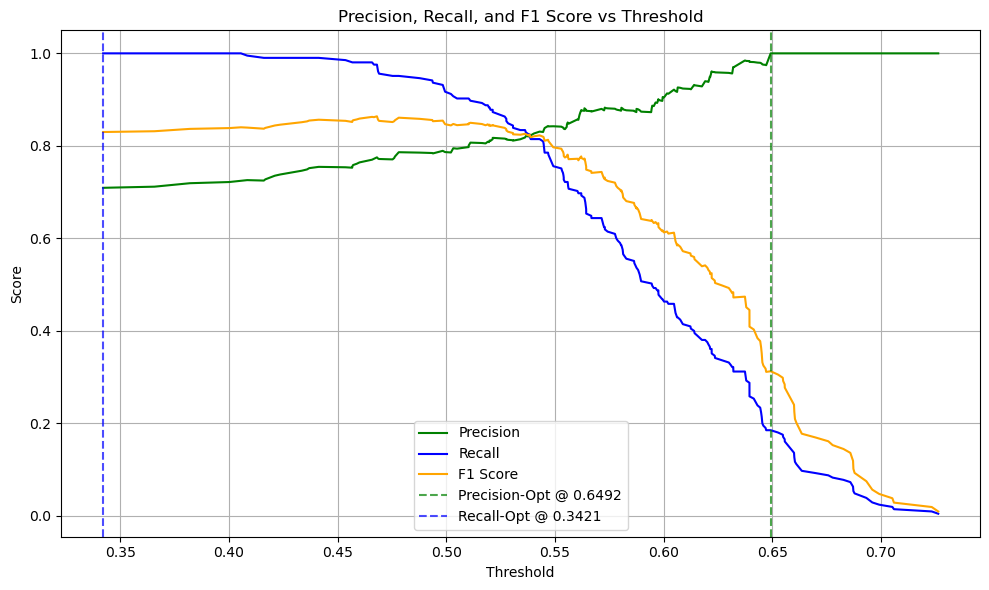

In [8]:
# Get the F1 scores for each threshold
f1_scores = [f1_score(y_test, (y_proba >= t).astype(int), zero_division=0) for t in thresholds]

# base setup of plot
plt.figure(figsize = (10,6))

# Plot precision, recall, and F1
plt.plot(thresholds, precision[:-1], label = 'Precision', color = 'green')
plt.plot(thresholds, recall[:-1], label = 'Recall', color = 'blue')
plt.plot(thresholds, f1_scores, label = 'F1 Score', color = 'orange')

# Mark the precision-optimized threshold
plt.axvline(precision_thresh, linestyle = '--', color = 'green', alpha = 0.7, label = f"Precision-Opt @ {precision_thresh:.4f}")

# Mark the recall-optimized threshold
plt.axvline(recall_thresh, linestyle = '--', color = 'blue', alpha = 0.7, label = f"Recall-Opt @ {recall_thresh:.4f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 Score vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The precision curve (green) shows a sharp increase as the threshold rises, peaking at 1.0 beyond ~0.65. This indicates that at higher thresholds, the model becomes extremely conservative — selecting only a few compounds but with perfect confidence in their predicted activity. However, this comes at the cost of missing many true actives.

The recall curve (blue) demonstrates the opposite pattern, beginning at 1.0 and declining steadily as the threshold increases. This reflects a broader catchment of actives at low thresholds (high sensitivity), which includes more false positives.

The F1 score curve (orange) remains relatively stable across a moderate threshold range and peaks around the balance point between precision and recall.

The precision-optimized threshold (~0.6492, green dashed line) corresponds to a very small number of high-confidence hits.

The recall-optimized threshold (~0.3421, blue dashed line) casts a wider net, capturing all true actives but with more noise.

**This plot supports our decision to emphasize high-confidence triage by selecting the precision-optimized threshold for downstream prioritization.**

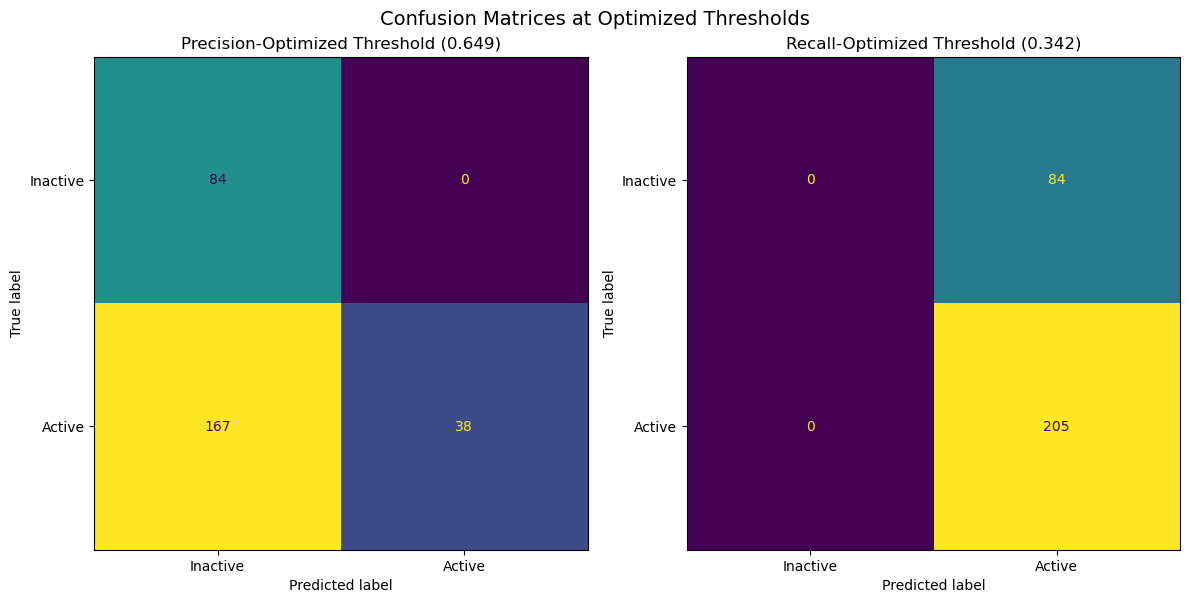

In [9]:
from sklearn.metrics import ConfusionMatrixDisplay

# Predictions at each optimized threshold
y_pred_precision = (y_proba >= precision_thresh).astype(int)
y_pred_recall = (y_proba >= recall_thresh).astype(int)

# Make the plots side by side this time
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# Plot Precision-Optimized Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_precision,
    display_labels = ["Inactive", "Active"],
    ax = axs[0],
    colorbar = False
)
axs[0].set_title(f"Precision-Optimized Threshold ({precision_thresh:.3f})")

# Plot Recall-Optimized Confusion Matrix
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_recall,
    display_labels = ["Inactive", "Active"],
    ax = axs[1],
    colorbar = False
)
axs[1].set_title(f"Recall-Optimized Threshold ({recall_thresh:.3f})")

plt.suptitle("Confusion Matrices at Optimized Thresholds", fontsize = 14)
plt.tight_layout()
plt.show()

##### Confusion Matrix Interpretation

The confusion matrices summarize classification performance at the precision-optimized and recall-optimized thresholds:

**Precision-Optimized Threshold (~0.649)**:

-38 active molecules correctly identified (True Positives).

-84 inactive molecules correctly rejected (True Negatives).

-167 active molecules missed (False Negatives) due to strict thresholding.

-0 inactive molecules incorrectly classified as active (False Positives).

**This threshold produces a highly precise shortlist of actives, ideal for minimizing wet lab waste.  However, the model sacrifices sensitivity, excluding a substantial portion of actives in favor of confidence.**

**Recall-Optimized Threshold (~0.342)**:

-205 active molecules correctly identified (True Positives).

-0 inactive molecules correctly rejected (True Negatives).

-0 active molecules missed (False Negatives).

-84 inactive molecules incorrectly classified as active (False Positives).

**Here, the model achieves full recall, ensuring that no potential actives are missed.  However, this comes with a significant tradeoff:  a larger, noisier hitlist that includes every inactive compound.**

#### Now let's just save our threshold with our predicted active values for use in the next notebook.

In [10]:
import json

# set path
threshold_path = Path("../artifacts/thresholds/phase1_thresholds.json").resolve()
threshold_path.parent.mkdir(parents = True, exist_ok = True) # ensure folder exists

# save threshold
threshold_data = {"precision_optimized_threshold": float(precision_thresh)}

with open(threshold_path, "w") as f:
    json.dump(threshold_data, f, indent = 4)

# confirm
print("Threshold saved to:", threshold_path)

Threshold saved to: /home/ryanm/BioPred_DS/artifacts/thresholds/phase1_thresholds.json


### Summary

#### In this notebook, we:

- Trained and evaluated 8 supervised classification models, using ROC AUC and PR AUC as key performance metrics.
- Identified XGBoost as the top-performing model, achieving a PR AUC score of 0.973 on held-out test data.
- Explored **Bayesian Optimization** with Optuna to further explore hyperparameter space, but ultimately retained the **original XGBoost** model due to stronger out-of-sample performance.
- Selected a precision-optimized threshold (~0.6492) to support **early-stage triage goals**, prioritizing high-confidence hits with minimal false positives.
- Visualized model performance through **Precision-Recall-F1 curves** and **confusion matrices** to contextualize classification tradeoffs.

- Saved all key artifacts--**trained model** ('.pkl'), **test predictions**(y_test, y_proba), and **threshold metadata**(.json)--to support downstream analysis in **Phase 1 Results** and enable full reproducability.

We are now well-positioned to advance into **Phase 1 Results**, where we will compute **enrichment factors**, assess **prioritized actives**, and validate performance through **biological interpretation and rediscovery**.

